Here we are trying to reconstuct the magnetic field using ESR scans.

## B field reconstruction from ESR

20211016 FF

Sample 38, box 1 - neodymium magnet on resonator

Using nanopillars

In [1]:
import sys

In [2]:
sys.path.append(r"C:\Users\Characterization\B26_scanning_probe\b26_toolkit")

In [3]:
import glob
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
from matplotlib import gridspec
from b26_toolkit.data_analysis import nv_optical_response as nv
from b26_toolkit.data_analysis import nv_analysis as nv_anal
from b26_toolkit.data_analysis import fields as fields
from pylabcontrol.core import Script as script
from b26_toolkit.data_processing import fit_functions as ff
import time
import uncertainties as uc
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import lmfit
import matplotlib 
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import string

# setup font styles for figures
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.weight' : 'normal'}
matplotlib.rcParams.update(params)

%matplotlib inline

import scipy.optimize as opt
from b26_toolkit.data_analysis.nv_optical_response import B_field_from_esr

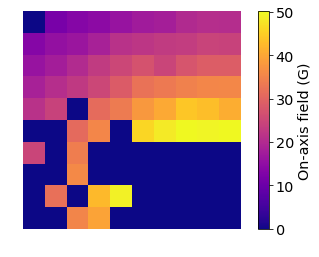

In [6]:
# filename of esr data
folder = r'C:\Users\Characterization\B26_scanning_probe\data\230131-10_41_19_attoscandigitalesr'
def get_fields(file):
    extent = script.load_data(file)['extent']
    fields = script.load_data(file)['point_value']
    return fields
    
field = get_fields(folder)
removed_pts = [[8,0],[9,0],[6,6],[12,10]]
fig,ax = plt.subplots()
im = ax.imshow(field,cmap='plasma')
cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label('On-axis field (G)')
plt.axis('off')
plt.savefig('20211015_field_scan.png',dpi=300,bbox_inches='tight',transparent=1)
plt.show()

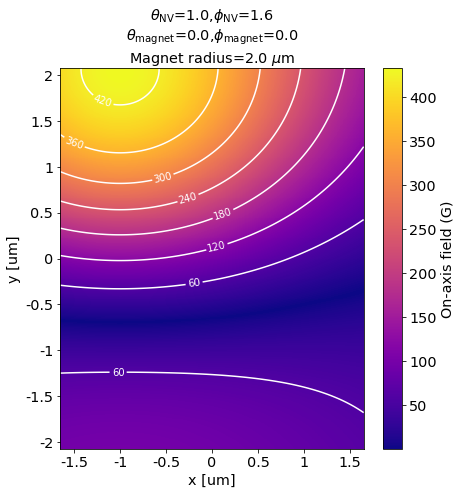

In [42]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

def dipole(x, y, z, m_theta, m_phi, nv_theta, nv_phi, m_loc_x, m_loc_y, b0):
    ny, nx = np.shape(x)
    z = np.array([[z for i in range(nx)] for j in range(ny)])
    r = np.array([x-m_loc_x, y-m_loc_y, z])
    m_prefactor = b0*4/3*np.pi*radius**3
    mx,my,mz = np.sin(m_theta)*np.cos(m_phi),np.sin(m_theta)*np.sin(m_phi),np.cos(m_theta)
    m = m_prefactor* np.array([np.tile(mx,(ny,nx)), np.tile(my,(ny,nx)), np.tile(mz,(ny,nx))])
    m_dot_r = np.sum(r*m,axis=0)
    r_abs = np.sqrt(np.sum(r*r,axis=0))
    field = 1/(4*np.pi)*((3*r*m_dot_r)/np.power(r_abs,5)- m/np.power(r_abs,3))
    nvx,nvy,nvz = np.sin(nv_theta)*np.cos(nv_phi),np.sin(nv_theta)*np.sin(nv_phi),np.cos(nv_theta)
    nvx_array, nvy_array, nvz_array = np.tile(nvx,(ny,nx)), np.tile(nvy,(ny,nx)), np.tile(nvz,(ny,nx))
    nv = np.array([nvx_array, nvy_array, nvz_array])
    field_nv = np.sum(field*nv,axis=0)*1e4
    return np.abs(field_nv)

radius = 2.e-6
m_dir = np.array([0,0])
nv_dir = np.array([np.pi*55/180,np.pi*90/180])
m_loc = np.array([-1,1])*1e-6

xmin, xmax, nx = -1.65e-6, 1.65e-6, 400
ymin, ymax, ny = -2.07e-6, 2.07e-6, 400
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

Z = dipole(X,Y,4e-6,*m_dir,*nv_dir,*m_loc, 0.7)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)

im = ax.imshow(Z, origin='bottom', cmap='plasma',
          extent=(x.min(), x.max(), y.min(), y.max()))
cont = ax.contour(X, Y, Z, colors='w')
plt.clabel(cont,fmt='%.0f')

cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label('On-axis field (G)')
nv_dir_norm = nv_dir/np.linalg.norm(nv_dir)
ax.set_title(r'$\theta_{{\mathrm{{NV}}}}$={:.1f},$\phi_{{\mathrm{{NV}}}}$={:.1f}' '\n' 
             r'$\theta_{{\mathrm{{magnet}}}}$={:.1f},$\phi_{{\mathrm{{magnet}}}}$={:.1f}' '\n' 
             r'Magnet radius={:.1f} $\mu$m'
             .format(*nv_dir,*m_dir,radius*1e6))
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
ax.set_xlabel('x [um]');ax.set_ylabel('y [um]')
plt.show()

In [35]:
   # Manually overwrite fields that had "bad" values. e.g. If the splitting is too large to be in the ESR range,
# the script will say it's 0. Sometimes the script sees a ZFS and just gives a bad fit that has two dips, 
# giving a wrong and large splitting.
field_data = get_fields(r'C:\Users\Characterization\B26_scanning_probe\data\230131-14_35_00_attoscandigitalesr')

print(field_data)

[[22.49792373 22.6404953  24.55767915 25.31758846 26.86481491 28.52193662
  30.6674828  30.92402903 31.14636417 30.4634821 ]
 [23.4848161  26.01159145 26.89775112 29.44016545 31.2824735  30.75232193
  34.23233251 33.63468493 33.89891151 32.60005797]
 [23.47776618 24.96617405 26.41111762 28.44954353 30.19936525 30.31316814
  31.27996394 31.44116933 31.55583605 30.70418306]
 [ 0.         23.40653782 25.94363128 26.09211124 28.07256099 29.9725795
  31.63521285 30.46367231 31.12916491 31.02438045]
 [20.93980779 22.04192661 22.53327366 24.04459192 25.02760752 25.5921668
   0.         30.21387918 31.9334135  31.23888949]
 [20.6271508  21.74626431 22.02280169 22.84564761 22.64126419 23.55969159
  23.63165919 23.6871418  23.11450989 23.17065618]
 [15.74904006 17.18679239 17.10438433 18.68991781 19.74575004 19.96053687
  20.5850111  20.7962516  21.09763808 20.30795084]
 [13.39285538 14.82939046 16.33470287 17.36972966  0.         19.1362074
  19.92798402 22.48229706 22.64873669 20.76210949]
 [1

In [36]:
# Manually set the bounds of the attoscan by comparing the two galvoscans to FindNV data,
# which is done externally in GIMP.
xmin, xmax, nx = volt2um(12), volt2um(19), np.shape(field_data)[1]
ymin, ymax, ny = volt2um(5), volt2um(12), np.shape(field_data)[0]
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Set magnet size
radius = 1e-6

def volt2um(volt):
    out = volt/75 * 20
    return out*1e-6

x_a = volt2um(15)
y_a = volt2um(4)
x_b = volt2um(22)
y_b = volt2um(10)
# Create our own error function: we use least squares in this case.

def _dipole_err(args):
    return np.sum(np.square(np.abs(dipole(X, Y, *args)-field_data)))

# z, m_theta, m_phi, nv_theta, nv_phi, m_loc_x, m_loc_y, b0

bounds = {'z':(3e-6,13e-6),
          'm_theta':(np.pi/180*0,np.pi/180*160),'m_phi':(np.pi/180*0,np.pi*360/180),
          'nv_theta':(np.pi/180*20,np.pi/180*160),'nv_phi':(np.pi/180*0,np.pi*360/180),
          'm_loc_x':(x_a,x_b),'m_loc_y':(y_a,y_b),
          'b0':(.05,2*1.3**3)}
bounds = [bounds[i] for i in ['z','m_theta','m_phi','nv_theta','nv_phi','m_loc_x','m_loc_y','b0']]

res = opt.differential_evolution(_dipole_err, bounds=bounds,maxiter=500, popsize=80, tol=0.01, polish=1)
print('Fitted parameters:')
print(res)

# Save fit results to csv
res['x'] = list(res['x'])
fit_file = open("dipole_fit.csv", "w")
writer = csv.writer(fit_file,delimiter=';')
for key, value in res.items():
    writer.writerow([key, value])
fit_file.close()

Fitted parameters:
     fun: 2286.9629500480805
     jac: array([ 1.13584204e+08, -1.21537597e+01, -2.73101706e+01,  3.31952380e+01,
        4.62641768e+00,  4.44369217e+07,  7.92777999e+07,  8.72185415e+01])
 message: 'Optimization terminated successfully.'
    nfev: 281698
     nit: 438
 success: True
       x: array([5.16938554e-06, 1.33044076e+00, 5.13072034e+00, 2.69433095e+00,
       4.57164519e+00, 4.08793105e-06, 2.42879534e-06, 1.16597582e+00])


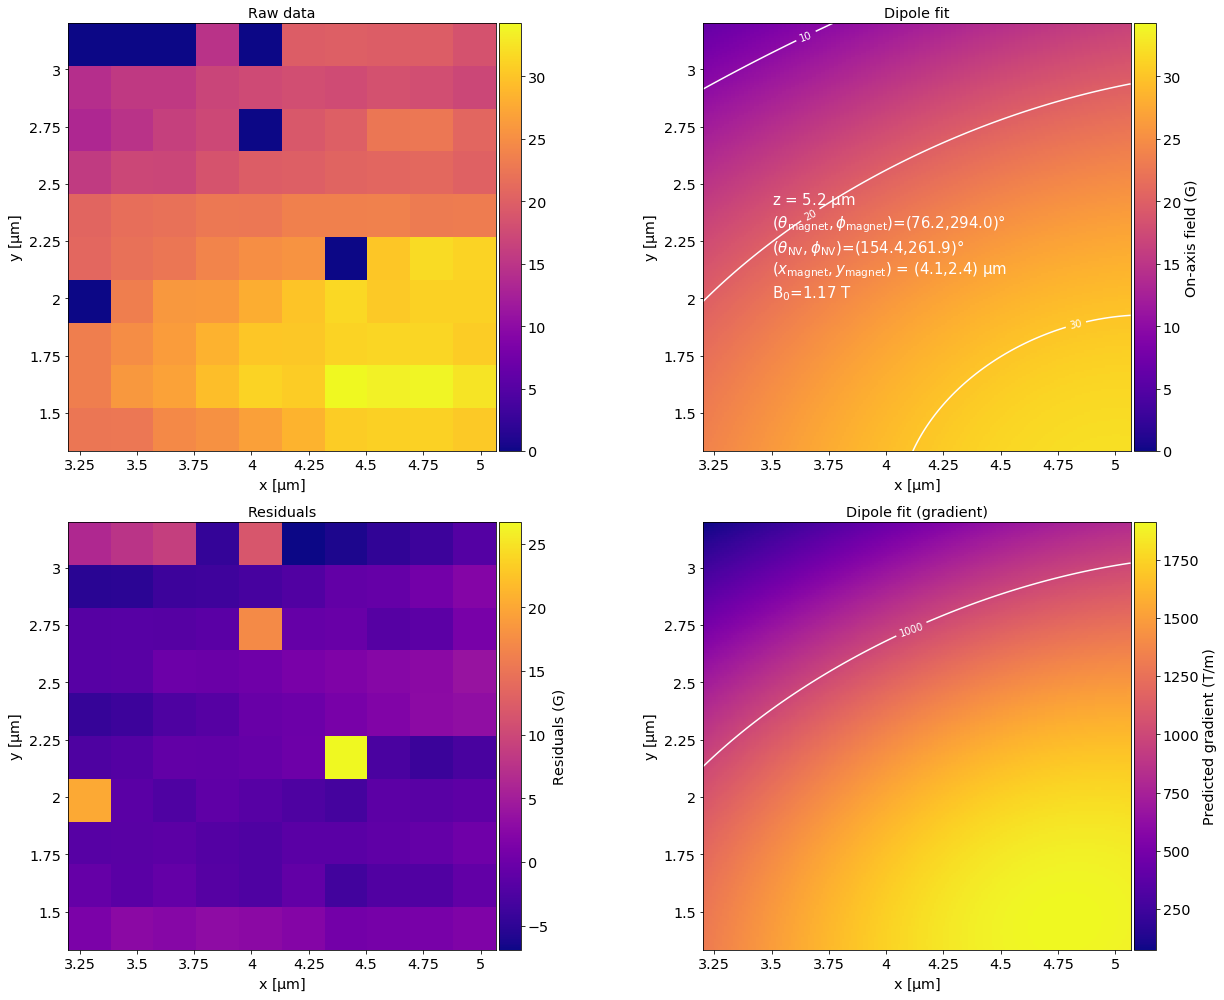

In [41]:
fig,axs = plt.subplots(2,2,figsize=(18,14))
axs = *axs[0],*axs[1]
ax1,ax2,ax3,ax4 = axs


# Plot raw data
im1 = ax1.imshow(field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
clim=im1.properties()['clim']
ax1.set_title('Raw data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, orientation='vertical',cax=cax)

# Plot fit
Z_fit = dipole(X,Y, *res['x'])
x_fine, y_fine = np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
Z_fine = dipole(X_fine,Y_fine, *res['x'])
im2 = ax2.imshow(Z_fine, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()),clim=clim)    
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, orientation='vertical',cax=cax)
cbar.set_label('On-axis field (G)')

res['x_plot'] = np.array(res['x'])
# Convert from radians to deg
for i in [1,2,3,4]:
    res['x_plot'][i] = res['x_plot'][i]/ np.pi * 180
# Convert from m to um
for i in [0,5,6]:
    res['x_plot'][i] = res['x_plot'][i]*1e6
    
ax2.set_title('Dipole fit')
ax2.text(3.5e-6,2e-6, 
         '\n' r'z = {:.1f} $\mathrm{{\mu}}$m' '\n'
         r'$(\theta_{{\mathrm{{magnet}}}},\phi_{{\mathrm{{magnet}}}})$=({:.1f},{:.1f})$\degree$' '\n' 
         r'$(\theta_{{\mathrm{{NV}}}},\phi_{{\mathrm{{NV}}}})$=({:.1f},{:.1f})$\degree$' '\n' 
         r'$(x_{{\mathrm{{magnet}}}},y_{{\mathrm{{magnet}}}})$ = ({:.1f},{:.1f}) $\mathrm{{\mu m}}$' '\n'
         r'$\mathrm{{B}}_0$={:.2f} T'
         .format(*res['x_plot']),fontsize=15,color='white')

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
cont2 = ax2.contour(X_fine, Y_fine, Z_fine, colors='w', levels=np.arange(0,90,10))
plt.clabel(cont2,fmt='%.0f')


# Plot residuals
im3 = ax3.imshow(Z_fit-field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
ax3.set_title('Residuals')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im3, orientation='vertical',cax=cax)
cbar.set_label('Residuals (G)')

for ax in axs:
    ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
    ax.set_xlabel(r'x [$\mathrm{{\mu m}}$]');ax.set_ylabel('y [$\mathrm{{\mu m}}$]')


# Plot gradient using dipole fit parameters
dz = 1e-10
Z_fine_grad = np.abs(dipole(X_fine,Y_fine,*[res['x'][0]+dz,*res['x'][1:]])-
                     dipole(X_fine,Y_fine,*[res['x'][0],*res['x'][1:]]))/dz*1e-4
im4 = ax4.imshow(Z_fine_grad, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, orientation='vertical',cax=cax)
cbar.set_label('Predicted gradient (T/m)')
cont4 = ax4.contour(X_fine, Y_fine, Z_fine_grad, colors='w',levels=np.arange(1000,12000,1000))
plt.clabel(cont4,fmt='%.0f')
ax4.set_title('Dipole fit (gradient)')

fig.tight_layout()
plt.savefig('plots/dipole_fit_diff_evol.png',dpi=400,bbox_inches='tight',transparent=1)
plt.show()

## Fit with lmfit (guessing with fit from diff evolution) to obtain error estimate in fit

In [ ]:
# Use lmfit
xmin, xmax, nx = -2.13e-6, 2.13e-6, np.shape(field_data)[1]
ymin, ymax, ny = -2.00e-6, 2.00e-6, np.shape(field_data)[0]
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

def dipole_reshape(x, y, nx, ny, *args):
    X = np.reshape(x, (ny,nx))
    Y = np.reshape(x, (ny,nx))
    result = np.ravel(dipole(X, Y, *args))
    return result

def _dipole(M, *args):
    x, y = M
    return dipole_reshape(x, y, nx, ny, *args)

# Give initial guess and bounds
bounds = {'z':[2e-6,(1e-6,9e-6)],
          'm_theta':[0,(np.pi/180*0,np.pi/180*20)],'m_phi':[0,(np.pi/180*0,np.pi*360/180)],
          'nv_theta':[np.pi*35/180,(np.pi/180*40,np.pi/180*140)],'nv_phi':[np.pi*90/180,(np.pi/180*0,np.pi*360/180)],
          'm_loc_x':[-1.8e-6,(-3e-6,-0e-6)],'m_loc_y':[0e-6,(-1.2e-6,1.2e-6)],
          'b0':[0.5,(.05,.7*1.3**3)]}

# Some bad guesses for testing
"""bounds = {'z':[5e-6,(1e-6,9e-6)],
          'm_theta':[20,(np.pi/180*0,np.pi/180*20)],'m_phi':[0,(np.pi/180*0,np.pi*360/180)],
          'nv_theta':[np.pi*75/180,(np.pi/180*40,np.pi/180*140)],'nv_phi':[np.pi*45/180,(np.pi/180*0,np.pi*360/180)],
          'm_loc_x':[-1.8e-6,(-3e-6,-0e-6)],'m_loc_y':[0e-6,(-1.2e-6,1.2e-6)],
          'b0':[0.5,(.05,.7*1.3**3)]}"""

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))


#popt, pcov = curve_fit(_dipole, xdata, field_data.ravel(), 
#                       p0=p0, bounds=bounds,maxfev = 2000,sigma=sigma.ravel(),absolute_sigma=1,method='dogbox')

def _dipole_err_lm(params, x, ydata):
    z = params['z'].value
    m_theta = params['m_theta'].value
    m_phi = params['m_phi'].value
    nv_theta = params['nv_theta'].value
    nv_phi = params['nv_phi'].value
    m_loc_x = params['m_loc_x'].value
    m_loc_y = params['m_loc_y'].value
    b0 = params['b0'].value
    args = z, m_theta, m_phi, nv_theta, nv_phi, m_loc_x, m_loc_y, b0

    err = np.abs(dipole(X, Y, *args)-field_data)
    return err

params = lmfit.Parameters()

for key in bounds.keys():
    bounds_pair = bounds[key]
    params.add(key, bounds[key][0], min=bounds_pair[1][0], max=bounds_pair[1][1])

#field_data = np.array(field_data, dtype=np.float32)
lm_soln = lmfit.minimize(_dipole_err_lm, params, args=(xdata, field_data.ravel()), method='nelder')
print("# Fit using leastsq:")
lmfit.report_fit(lm_soln)

In [ ]:
fig,axs = plt.subplots(2,2,figsize=(18,14))
axs = *axs[0],*axs[1]
ax1,ax2,ax3,ax4 = axs


# Plot raw data
im1 = ax1.imshow(field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
clim=im1.properties()['clim']
ax1.set_title('Raw data')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, orientation='vertical',cax=cax)

# Plot fit
lm_soln_fit = [lm_soln.params[key] for key in lm_soln.params.keys()]

Z_fit = dipole(X,Y, *lm_soln_fit)
x_fine, y_fine = np.linspace(xmin, xmax, 80), np.linspace(ymin, ymax, 80)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

Z_fine = dipole(X_fine,Y_fine, *lm_soln_fit)
im2 = ax2.imshow(Z_fine, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()),clim=clim)    
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, orientation='vertical',cax=cax)
cbar.set_label('On-axis field (G)')

res['x_plot'] = np.array(lm_soln_fit)
# Convert from radians to deg
for i in [1,2,3,4]:
    res['x_plot'][i] = res['x_plot'][i]/ np.pi * 180
# Convert from m to um
for i in [0,5,6]:
    res['x_plot'][i] = res['x_plot'][i]*1e6
    
ax2.set_title('Dipole fit')
ax2.text(-.35e-6,-.8e-6, 
         '\n' r'z = {:.1f} $\mathrm{{\mu}}$m' '\n'
         r'$(\theta_{{\mathrm{{magnet}}}},\phi_{{\mathrm{{magnet}}}})$=({:.1f},{:.1f})$\degree$' '\n' 
         r'$(\theta_{{\mathrm{{NV}}}},\phi_{{\mathrm{{NV}}}})$=({:.1f},{:.1f})$\degree$' '\n' 
         r'$(x_{{\mathrm{{magnet}}}},y_{{\mathrm{{magnet}}}})$ = ({:.1f},{:.1f}) $\mathrm{{\mu m}}$' '\n'
         r'$\mathrm{{B}}_0$={:.2f} T'
         .format(*res['x_plot']),fontsize=15,color='white')

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
cont2 = ax2.contour(X_fine, Y_fine, Z_fine, colors='w', levels=np.arange(0,90,10))
plt.clabel(cont2,fmt='%.0f')


# Plot residuals
im3 = ax3.imshow(Z_fit-field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
ax3.set_title('Residuals')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im3, orientation='vertical',cax=cax)
cbar.set_label('Residuals (G)')

for ax in axs:
    ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
    ax.set_xlabel(r'x [$\mathrm{{\mu m}}$]');ax.set_ylabel('y [$\mathrm{{\mu m}}$]')


# Plot gradient using dipole fit parameters
dz = 1e-10
Z_fine_grad = np.abs(dipole(X_fine,Y_fine,*[res['x'][0]+dz,*res['x'][1:]])-
                     dipole(X_fine,Y_fine,*[res['x'][0],*res['x'][1:]]))/dz*1e-4
im4 = ax4.imshow(Z_fine_grad, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, orientation='vertical',cax=cax)
cbar.set_label('Predicted gradient (T/m)')
cont4 = ax4.contour(X_fine, Y_fine, Z_fine_grad, colors='w',levels=np.arange(1000,12000,1000))
plt.clabel(cont4,fmt='%.0f')
ax4.set_title('Dipole fit (gradient)')

fig.tight_layout()
plt.savefig('dipole_fit.png',dpi=300,bbox_inches='tight',transparent=1)
plt.show()

## Make plot for paper
Three subplots

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(18,6))
ax1,ax2,ax4 = axs

# Plot raw data
im1 = ax1.imshow(field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
clim=im1.properties()['clim']
ax1.set_title('Measured Field')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, orientation='vertical',cax=cax)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, orientation='vertical',cax=cax)
cbar.set_label('On-axis Field (G)')


# Plot fit
lm_soln_fit = [lm_soln.params[key] for key in lm_soln.params.keys()]

Z_fit = dipole(X,Y, *lm_soln_fit)
x_fine, y_fine = np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

Z_fine = dipole(X_fine,Y_fine, *lm_soln_fit)
im2 = ax2.imshow(Z_fine, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()),clim=clim)    
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im2, orientation='vertical',cax=cax)
cbar.set_label('On-axis Field (G)')

res['x_plot'] = np.array(lm_soln_fit)
# Convert from radians to deg
for i in [1,2,3,4]:
    res['x_plot'][i] = res['x_plot'][i]/ np.pi * 180
# Convert from m to um
for i in [0,5,6]:
    res['x_plot'][i] = res['x_plot'][i]*1e6
    
ax2.set_title('Field from Dipole Model Fit')


ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
cont2 = ax2.contour(X_fine, Y_fine, Z_fine, colors='w', levels=np.arange(0,100,10))
plt.clabel(cont2,fmt='%.0f',fontsize=12)

fontprops = fm.FontProperties(size=18)
for n,ax in enumerate(axs):
    #ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
    #ax.set_xlabel(r'x [$\mathrm{{\mu m}}$]');ax.set_ylabel('y [$\mathrm{{\mu m}}$]')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    scalebar = AnchoredSizeBar(ax.transData,
                               1e-6, '1 $\mathrm{{\mu m}}$', 'lower right', 
                               #pad=0.5,
                               color='white',
                               frameon=False,
                               size_vertical=1e-7,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)
    ax.text(-0.05, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

# Plot gradient using dipole fit parameters
dz = 1e-12
Z_fine_grad = np.abs(dipole(X_fine,Y_fine,*[res['x'][0]+dz,*res['x'][1:]])-
                     dipole(X_fine,Y_fine,*[res['x'][0],*res['x'][1:]]))/dz*1e-4
im4 = ax4.imshow(Z_fine_grad*1e-3, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, orientation='vertical',cax=cax)
cbar.set_label('On-axis Field Gradient (kT/m)')
cont4 = ax4.contour(X_fine, Y_fine, Z_fine_grad, colors='w',levels=np.arange(2000,12000,2000))
plt.clabel(cont4,fmt='%.0f',fontsize=12)
ax4.set_title('Field Gradient from Dipole Model Fit')

fig.tight_layout()
plt.savefig('dipole_fit_paper.png',dpi=300,bbox_inches='tight',transparent=1)
plt.show()

## Make plot for paper
Fit superimposed on data

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(18,6))
ax1,ax4 = axs


# Plot raw data
im1 = ax1.imshow(field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
clim=im1.properties()['clim']
ax1.set_title('Measured Field')
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im1, orientation='vertical',cax=cax)
cbar.set_label('On-axis Field (G)')

# Plot fit
lm_soln_fit = [lm_soln.params[key] for key in lm_soln.params.keys()]

Z_fit = dipole(X,Y, *lm_soln_fit)
x_fine, y_fine = np.linspace(xmin, xmax, 80), np.linspace(ymin, ymax, 80)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)

Z_fine = dipole(X_fine,Y_fine, *lm_soln_fit)



res['x_plot'] = np.array(lm_soln_fit)
# Convert from radians to deg
for i in [1,2,3,4]:
    res['x_plot'][i] = res['x_plot'][i]/ np.pi * 180
# Convert from m to um
for i in [0,5,6]:
    res['x_plot'][i] = res['x_plot'][i]*1e6
    
ax2.set_title('Measured Field Fitted to Dipole Model')


ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
cont1 = ax1.contour(X_fine, Y_fine, Z_fine, colors='w', levels=np.arange(0,100,10))
plt.clabel(cont1,fmt='%.0f',fontsize=12)


for ax in axs:
    ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
    ax.set_xlabel(r'x [$\mathrm{{\mu m}}$]');ax.set_ylabel('y [$\mathrm{{\mu m}}$]')


# Plot gradient using dipole fit parameters
dz = 1e-12
Z_fine_grad = np.abs(dipole(X_fine,Y_fine,*[res['x'][0]+dz,*res['x'][1:]])-
                     dipole(X_fine,Y_fine,*[res['x'][0],*res['x'][1:]]))/dz*1e-4
im4 = ax4.imshow(Z_fine_grad, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))    
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im4, orientation='vertical',cax=cax)
cbar.set_label('On-axis Field Gradient (T/m)')
cont4 = ax4.contour(X_fine, Y_fine, Z_fine_grad, colors='w',levels=np.arange(0,12000,1500))
plt.clabel(cont4,fmt='%.0f',fontsize=12)
ax4.set_title('Field Gradient from Dipole Model')

fig.tight_layout()
plt.savefig('dipole_fit_paper.png',dpi=300,bbox_inches='tight',transparent=1)
plt.show()

## 2D curve fitting example

In [ ]:
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='bottom', cmap='plasma',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()

## Curvefit doesn't work that well...

In [ ]:
# Manually overwrite fields that had "bad" values. e.g. If the splitting is too large to be in the ESR range,
# the script will say it's 0. Sometimes the script sees a ZFS and just gives a bad fit that has two dips, 
# giving a wrong and large splitting.
field_data = get_fields('211015-01_15_19_attoscandcesr')
field_data[8,0] = 75
field_data[9,0] = 75
field_data[6,6] = 0
field_data[12,10] = 0

xmin, xmax, nx = -2.13e-6, 2.13e-6, np.shape(field_data)[1]
ymin, ymax, ny = -2.00e-6, 2.00e-6, np.shape(field_data)[0]
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

def dipole_reshape(x, y, nx, ny, *args):
    X = np.reshape(x, (ny,nx))
    Y = np.reshape(x, (ny,nx))
    result = np.ravel(dipole(X, Y, *args))
    return result

def _dipole(M, *args):
    x, y = M
    return dipole_reshape(x, y, nx, ny, *args)

# Give initial guess and bounds
bounds = {'z':[2e-6,(1e-6,9e-6)],
          'm_theta':[0,(np.pi*-20./180,np.pi*20./180)],'m_phi':[0,(np.pi*-180/180,np.pi*180/180)],
          'nv_theta':[np.pi*57/180,(-np.pi/180*20,np.pi/180*90)],'nv_phi':[np.pi*90/180,(-np.pi*70/180,np.pi*130/180)],
          'm_loc_x':[-1.8e-6,(-2.5e-6,-1.5e-6)],'m_loc_y':[0e-6,(-1.2e-6,1.2e-6)],
          'b0':[0.3,(.05,.7*1.3**3)]}
p0 = [bounds[key][0] for key in ['z','m_theta','m_phi','nv_theta','nv_phi','m_loc_x','m_loc_y','b0']]
bounds = [bounds[key][1] for key in ['z','m_theta','m_phi','nv_theta','nv_phi','m_loc_x','m_loc_y','b0']]
bounds = np.transpose(bounds)

# Assign different errors: pts with 0 field probably actually had non-zero splitting that
# the script failed to fit.
sigma = np.array([[4 if i ==0 else .35 for i in j] for j in field_data])

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))

# Do the fit, using our custom _dipole function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_dipole, xdata, field_data.ravel(), 
                       p0=p0, bounds=bounds,maxfev = 2000,sigma=sigma.ravel(),absolute_sigma=1,method='dogbox')
print('Fitted parameters:')
print(popt)

fig,axs = plt.subplots(1,2,figsize=(13,5))
ax1,ax2 = axs
Z = dipole(X,Y, *popt)
im1 = ax1.imshow(field_data, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()))
clim=im1.properties()['clim']
im2 = ax2.imshow(Z, origin='bottom', cmap='plasma',extent=(x.min(), x.max(), y.min(), y.max()),clim=clim)    
cbar = fig.colorbar(im2, orientation='vertical')
cbar.set_label('On-axis field (G)')

for ax,data in zip(axs,[field_data,Z]):
    ax.xaxis.set_major_formatter(ticks);ax.yaxis.set_major_formatter(ticks)
    ax.set_xlabel('x [um]');ax1.set_ylabel('y [um]')

ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6))
plt.show()